# Working BNN codes 

## Very simple example 
https://github.com/Harry24k/bayesian-neural-network-pytorch/blob/master/demos/Bayesian%20Neural%20Network%20Regression.ipynb

Harry24k

In [ ]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
x = torch.linspace(-2, 2, 500)
y = x.pow(3) - x.pow(2) + 3*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [ ]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1),
)


mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
kl_weight = 0.1
for step in range(3000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

In [ ]:
x_test = torch.linspace(-2, 2, 500)
y_test = x_test.pow(3) - x_test.pow(2) + 3*torch.rand(x_test.size())

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.scatter(x_test.data.numpy(), y_test.data.numpy(), color='k', s=2) 

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'r-', linewidth=5, label='First Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'b-', linewidth=5, label='Second Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'g-', linewidth=5, label='Third Prediction')

plt.legend()

plt.show()

## Theory to Practice
https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825/

Piero Paialunga

In [ ]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

In [ ]:
x = torch.linspace(-2, 2, 500)
y = x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [ ]:
def clean_target(x):
    return x.pow(5) -10* x.pow(1)+1
def target(x):
    return x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())

In [ ]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=1),
)

In [ ]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

for step in range(10000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

In [ ]:
x_test = torch.linspace(-2, 2, 300)
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)

In [ ]:
models_result = np.array([model(x_test).data.numpy() for k in range(10000)])
models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(x_test.data.numpy(),mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(x_test.data.numpy().T[0],mean_values-6.0*std_values,mean_values+6.0*std_values,alpha=0.2,color='navy',label='99.7% confidence interval')
#plt.plot(x_test.data.numpy(),mean_values,color='darkorange')
plt.plot(x_test.data.numpy(),y_test.data.numpy(),'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_test.data.numpy(),clean_target(x_test).data.numpy(),color='green',markersize=4,label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

## ChatGPT simple code without pyro

In [ ]:
# -------------------------
# BayesianLinear Layer
# -------------------------
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Mean and rho for weights
        self.mu_W = nn.Parameter(torch.zeros(out_features, in_features))
        self.rho_W = nn.Parameter(torch.zeros(out_features, in_features))
        # Mean and rho for bias
        self.mu_b = nn.Parameter(torch.zeros(out_features))
        self.rho_b = nn.Parameter(torch.zeros(out_features))
        
        # Prior parameters for p(w) = Normal(0, std=1)
        self.prior_mu = 0.0
        self.prior_sigma = 1.0
        
    def forward(self, x):
        """
        Sample weights and bias using reparameterization:
            W = mu_W + log(1 + exp(rho_W)) * eps
        where eps ~ Normal(0,1).
        """
        sigma_W = torch.log1p(torch.exp(self.rho_W))  # ensure positivity
        sigma_b = torch.log1p(torch.exp(self.rho_b))
        
        eps_W = torch.randn_like(self.mu_W)
        eps_b = torch.randn_like(self.mu_b)
        
        W = self.mu_W + sigma_W * eps_W
        b = self.mu_b + sigma_b * eps_b
        
        return torch.matmul(x, W.t()) + b
    
    def kl_divergence(self):
        """
        Analytic KL(q||p) for each weight & bias param 
        when p ~ N(0,1) and q ~ N(mu, sigma^2).
        
        KL for one param ~ log(σ_p / σ_q) + 
                           (σ_q^2 + (μ_q - μ_p)^2)/(2 σ_p^2) - 1/2
        Here: μ_p=0, σ_p=1.
        So, KL ~ log(1/sigma_q) + (sigma_q^2 + mu_q^2)/2 - 1/2
        We'll sum over all elements.
        """
        sigma_W = torch.log1p(torch.exp(self.rho_W))
        sigma_b = torch.log1p(torch.exp(self.rho_b))
        
        # KL for the weights
        kl_W = (torch.log(self.prior_sigma / sigma_W) +
                 0.5 * (sigma_W.pow(2) + self.mu_W.pow(2)) - 0.5)
        kl_b = (torch.log(self.prior_sigma / sigma_b) +
                 0.5 * (sigma_b.pow(2) + self.mu_b.pow(2)) - 0.5)
        
        return kl_W.sum() + kl_b.sum()

# -------------------------
# Simple BNN Model
# -------------------------
class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, hidden_dim)
        self.blinear2 = BayesianLinear(hidden_dim, hidden_dim)  # Added one more hidden layer
        self.blinear3 = BayesianLinear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.blinear1(x)
        x = self.tanh(x)
        x = self.blinear2(x)
        x = self.tanh(x)
        x = self.blinear3(x)
        return x
    
    def kl_divergence(self):
        return (self.blinear1.kl_divergence() + 
                self.blinear2.kl_divergence() + 
                self.blinear3.kl_divergence())

# -------------------------
# Generate Synthetic Data
# -------------------------
torch.manual_seed(42)
N = 50
X = torch.linspace(-3, 3, N).unsqueeze(1)  # shape [N,1]
true_w, true_b = 2.0, 1.0
y_true = true_w * X*(X) + true_b
y_noise = y_true + 0.5 * torch.randn_like(y_true)

# -------------------------
# Instantiate Model
# -------------------------
model = BayesianNN(input_dim=1, hidden_dim=20, output_dim=1)
optimizer = optim.Adam(model.parameters(), lr=0.03)

# -------------------------
# Training Loop
# -------------------------
num_epochs = 5000
loss_history = []

# We'll treat the negative log-likelihood as an MSE (Gaussian assumption).
mse_loss = nn.MSELoss(reduction='sum')

beta = 1.0  # scale factor for KL term (can be adjusted)

for epoch in range(num_epochs):
    model.train()
    
    # 1) Forward pass (sample from q(w))
    y_pred = model(X)
    
    # 2) Compute negative log-likelihood (MSE here)
    nll = mse_loss(y_pred, y_noise)  # sum of squared errors
    
    # 3) KL divergence (sum of all BayesianLinear layers)
    kl = model.kl_divergence()
    
    # 4) Negative ELBO = NLL + beta * KL
    loss = nll + beta * kl
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} (NLL={nll.item():.4f}, KL={kl.item():.4f})")

# -------------------------
# Plot Training Curve
# -------------------------
plt.plot(loss_history, label='Negative ELBO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# -------------------------
# Illustrate Predictions
# -------------------------
model.eval()

# We'll draw multiple samples from the model to show uncertainty
with torch.no_grad():
    X_test = torch.linspace(-4, 4, 100).unsqueeze(1)
    predictions = []
    num_samples = 100
    for _ in range(num_samples):
        y_samp = model(X_test)
        predictions.append(y_samp)
    
    # Tensor of shape [num_samples, len(X_test), 1]
    preds = torch.stack(predictions)
    
    # Mean and std across samples
    mean_pred = preds.mean(dim=0).squeeze()
    std_pred = preds.std(dim=0).squeeze()

plt.figure(figsize=(8,5))
plt.plot(X_test.squeeze(), mean_pred, 'b-', label='Predictive mean')
plt.fill_between(
    X_test.squeeze(),
    mean_pred - 2*std_pred,
    mean_pred + 2*std_pred,
    color='b',
    alpha=0.2,
    label='±2 std. dev.'
)
plt.scatter(X.squeeze(), y_noise.squeeze(), c='r', marker='x', label='Data')
plt.title("Posterior Predictive Distribution (Toy BNN)")
plt.legend()
plt.show()


## Neural net for a sine curve 

In [ ]:
#dependencies 
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim

#generating and visualizing dataset
x = np.linspace(-4 * np.pi, 4 * np.pi, 10000)
y = np.sin(x) + 0.5 * np.random.randn(len(x))

plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.title("Sine Function with Random Noise")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [ ]:
#transforming the input and output arrays to tensors
x_tensor = torch.from_numpy(x).float().view(-1, 1)
y_tensor = torch.from_numpy(y).float().view(-1, 1)

#implementing the model
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden = nn.Linear(1, 128)
    self.hidden2 = nn.Linear(128, 256)
    self.hidden3 = nn.Linear(256, 128)
    self.output = nn.Linear(128, 1)
  
  def forward(self, x):
    x = torch.relu(self.hidden(x))
    x = torch.relu(self.hidden2(x))
    x = torch.relu(self.hidden3(x))
    x = self.output(x)
    return x

#instantiating the model, criterion (loss function), and optimizer
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#training loop
num_epochs = 1000
for epoch in range(num_epochs):
  #forward pass
  outputs = model(x_tensor)
  loss = criterion(outputs, y_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 100 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

#inference and visualization

# Test the trained model
with torch.no_grad():
    predicted = model(x_tensor)

# Plot the original function and the learned function
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Original Function')
plt.plot(x, predicted.numpy(), color='red', label='Learned Function')
plt.title("Original Function vs. Learned Function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

## ProbAI BNN MFVI

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

In [ ]:
def normalise_data(x, mean, std):
    return (x - mean) / std

def unnormalise_data(x, mean, std):
    return x * std + mean

class regression_data(Dataset):
     def __init__(self, x, y, normalise=True):
         super(regression_data, self).__init__()
         self.update_data(x, y, normalise)

     def __len__(self):
         return self.x.shape[0]

     def __getitem__(self, index):
         x = torch.tensor(self.x[index]).float()
         y = torch.tensor(self.y[index]).float()
         return x, y

     def update_data(self, x, y, normalise=True, update_stats=True):
         assert x.shape[0] == y.shape[0]
         self.x = x
         self.y = y
         # normalise data
         self.normalise = normalise
         if update_stats:
             self.x_mean = self.x.mean(0) if normalise else 0.0
             self.x_std = self.x.std(0) if normalise else 1.0
             self.y_mean = self.y.mean(0) if normalise else 0.0
             self.y_std = self.y.std(0) if normalise else 1.0
         if self.normalise:
             self.x = normalise_data(self.x, self.x_mean, self.x_std)
             self.y = normalise_data(self.y, self.y_mean, self.y_std)

In [ ]:
#Making y 

EPS = 1e-5  # define a small constant for numerical stability control

import math
def ground_truth_func(x):
    return np.cos(x * math.pi / 2 + 0.8) * np.exp(-0.1 * np.abs(x)) + 0.1 * x
def gen_data(N_data, ground_truth_func, noise_std=None): 
    # generate the training dataset, note here we will make data into 2 clusters
    x1 = np.random.randn(int(N_data/2), 1) * 0.5 + 2.0
    x2 = np.random.randn(int(N_data/2), 1) * 0.5 - 2.0
    x = np.concatenate([x1, x2], axis=0)
    y = ground_truth_func(x)
    if noise_std is not None and noise_std > EPS:
        # assume homogeneous noise setting, i.e., "homoscedasticity"
        y += np.random.randn(y.shape[0], y.shape[1]) * noise_std
    return x, y

N_data = 100
noise_std = 0.1
x_train, y_train = gen_data(N_data, ground_truth_func, noise_std)

dataset = regression_data(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True) 

In [ ]:
for _, (x, y) in enumerate(dataset):
    print(x,y)
    break

In [ ]:
def gauss_loglik(y, y_pred, log_noise_var):
    # y should have shape as (batch_size, y_dim)
    # y_pred should have shape as (batch_size, y_dim) or (K, batch_size, y_dim)
    # where K is the number of MC samples
    # this function should return per-data loss of shape (batch_size,) or (K, batch_size)
    ### begin of your code ###
    # hint: consult with your textbook or wikipedia for the Gaussian distribution form
    l2_dist=(y-y_pred).pow(2).sum(-1)
    ll = -0.5 * (log_noise_var + math.log(2 * math.pi) + l2_dist * torch.exp(-log_noise_var))

    ### end of your code ###
    return ll

# we assume a Gaussian likelihood with homogeneuous noise
log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# define the regression loss: negative gaussian log-likelihood
data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)

In [ ]:
# collect the kl divergence for all MFVILinear layers
def kl_divergence(bnn):
    kl = 0.0
    for module in bnn:
        if hasattr(module, 'kl_divergence'):
            kl = kl + module.kl_divergence()
    return kl

In [ ]:
# define the training function
def train_step(net, opt, data_loss_func, dataloader, N_data, beta=1.0):
    for _, (x, y) in enumerate(dataloader):
        x = x.to(device); y = y.to(device)
        opt.zero_grad() # opt is the optimiser
        y_pred = net(x)
        ### begin of your code ###
        # notice we might use mini-batches, so be careful for the right data-count!

        nll = data_loss_func(y, y_pred).mean()
        kl = kl_divergence(net)
        loss = N_data * nll + beta * kl

        ### end of your code ###

        loss.backward()
        opt.step()
    return nll, kl


def train_network(net, opt, dataloader, data_loss_func, learning_rate=1e-3,
                  N_epochs=2000, beta=1.0, verbose=True):
    # net.train() #makes the network trainable (in case it has some layers like dropout)
    logs = []
    for i in range(N_epochs):
        nll, kl = train_step(net, opt, data_loss_func, dataloader,
                          N_data=len(dataloader.dataset), beta=beta)
        logs.append([to_numpy(nll), to_numpy(kl)])
        if (i+1) % 500 == 0 and verbose:
            print("Epoch {}, nll={}, kl={}".format(i+1, logs[-1][0], logs[-1][1]))
    return np.array(logs)


# hyper-parameters of training
beta = 1.0
N_epochs = 2000
# training the network:
training = train_network(mfvi_regression_net, opt, dataloader, data_loss_func,
                     beta=beta, verbose=True, N_epochs=N_epochs)

## ChatGPT simple MC dropout NN

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define a simple neural network with Dropout
class MCDropoutNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 100)
        self.dropout = nn.Dropout(0.2)  # Dropout layer
        self.fc2 = nn.Linear(100, 100)
        self.dropout = nn.Dropout(0.2)  # Dropout layer
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout applied at inference too!
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  # Dropout applied at inference too!
        x = self.fc3(x)
        return x

# Generate toy dataset 
# torch.manual_seed(42)
X_train = torch.linspace(-3, 3, 300).reshape(-1, 1)
y_train = X_train + torch.randn_like(X_train) * 0.2  # Add noise

# Initialize model and optimizer
model = MCDropoutNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the model
for epoch in range(10000):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

# Function for MC Dropout inference
def mc_dropout_prediction(model, x, n_samples=1000):
    model.train()  # Keep dropout enabled
    preds = torch.stack([model(x) for _ in range(n_samples)]).squeeze()
    return preds.mean(dim=0), preds.std(dim=0,unbiased=False)  # Mean prediction & uncertainty

# Predict on new data
X_test = torch.linspace(-3, 3, 100).reshape(-1, 1)
mean_pred, std_pred = mc_dropout_prediction(model, X_test)


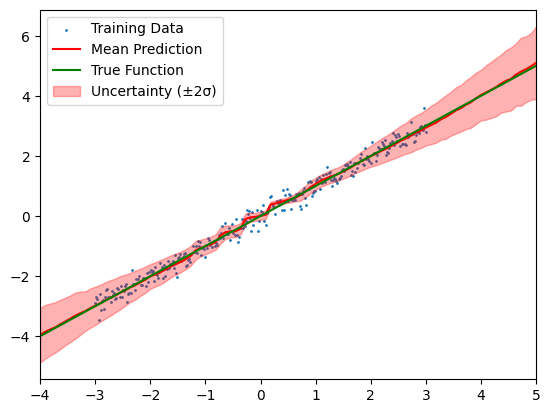

In [ ]:
# Plot results
plt.scatter(X_train, y_train, label="Training Data",s=1)
plt.plot(X_test, mean_pred.detach(), label="Mean Prediction", color="red")
plt.plot(X_test, X_test, label="True Function", color="green")
plt.fill_between(X_test.flatten(), 
                 (mean_pred - 2 * std_pred).detach().numpy(), 
                 (mean_pred + 2 * std_pred).detach().numpy(), 
                 color='red', alpha=0.3, label="Uncertainty (±2σ)")
plt.legend()
plt.show()